# Overview
1. Constants
2. Downloading Data
3. Turning off Randomness (optional)
4. Data Loader
5. Model Implementation
    - Feature Extraction
    - Hypergraph Construction
    - ROI - ROI Message Passing
    - Classification Head
    - Building the model
6. Training
    - Compiling 
    - Visualising the computational graph
    - Fitting the model
    - Plotting Accuract and Loss
7. Testing
8. Evaluation 
9. Training on different combinations of tasks and window sizes
10. Inspecting the Output of the TemporalHypergraphLayer.

In [29]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_gnn as tfgnn
import hypernetx as hnx
import seaborn as sns
import matplotlib.pyplot as plt

# Constants
Provided by [Neuromatch Academy](https://github.com/NeuromatchAcademy/course-content/blob/main/projects/fMRI/load_hcp_task.ipynb).

In [30]:
# The download cells will store the data in nested directories starting here:

HCP_DIR = "data/hcp/hcp_task"
# make the directory if it doesn't exist
if not os.path.isdir(HCP_DIR):
  os.makedirs(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# Run mapping
RUN_DIRECTION = {'RL': 0, 'LR': 1}

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.
Code provided by [Neuromatch Academy](https://github.com/NeuromatchAcademy/course-content/blob/main/projects/fMRI/load_hcp_task.ipynb).

The data is already provided in the GitHub Repository so there should be no need to download it again.

In [31]:
# # @title Download the data

# import os, requests, tarfile

# fname = "hcp_task.tgz"
# url = "https://osf.io/s4h8j/download/"

# if not os.path.isfile(fname):
#   try:
#     r = requests.get(url)
#   except requests.ConnectionError:
#     print("!!! Failed to download data !!!")
#   else:
#     if r.status_code != requests.codes.ok:
#       print("!!! Failed to download data !!!")
#     else:
#       print(f"Downloading {fname}...")
#       with open(fname, "wb") as fid:
#         fid.write(r.content)
#       print(f"Download {fname} completed!")

In [32]:
# # @title Extract the data in `HCP_DIR`
# fname_ex = "hcp_task"
# path_name = os.path.join(HCP_DIR, fname_ex)
# if not os.path.exists(path_name):
#   print(f"Extracting {fname_ex}.tgz...")
#   with tarfile.open(f"{fname_ex}.tgz") as fzip:
#     fzip.extractall(HCP_DIR)
# else:
#   print(f"File {fname_ex}.tgz has already been extracted.")

# Turning off Randomness
This is optional. Uncomment for deterministic behaviour.

In [33]:
# Set seeds for reproducibility

# Set the seed for NumPy functions
np.random.seed(42)

# Set the seed for Python's built-in random module (optional, for other random functionalities you might use)
import random
random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Data Loader


In [70]:
class DataLoader:

    def __init__(self, batch_size, subjects, tasks, dir, run_direction, s_max, random_state=None):
        """
        Initialise the DataLoader. Loads the data and performs a train-val-test split.
        
        Args:
            batch_size (int): Number of instances in a single batch.
            subjects (list): List of subject indices.
            tasks (list): List of task names.
            dir (str): Path to the data directory.
            run_direction (int): Run direction of the fMRI scan to be considerd, 'RL' or 'LR'.
            s_max (int): Maximum window length.
            random_state (int): Random seed, set for a deterministic train-val-test split.
        """
        self.batch_size = batch_size
        self.subjects = subjects
        self.tasks = tasks
        self.dir = dir
        self.run_direction = run_direction
        self.s_max = s_max
        self.random_state = random_state
        # Load and prepare data for all subjects and experiments
        self.subjects_data, self.max_seq_len = self._load_and_prepare_data()
        # Split data
        self.train_data, self.train_labels, self.val_data, self.val_labels, self.test_data, self.test_labels = self._train_val_test_split(random_state=random_state)
        self.all_labels = self.train_labels + self.val_labels + self.test_labels
        self.unique_labels = list(set(self.train_labels) | set(self.val_labels) | set(self.test_labels))

    def _encode_labels(self, y):
        """
        Encode string labels to integers.

        Args:
            y (array): Array of string labels.

        Returns:
            array: Array of integer labels.
        """
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)
        return y_encoded
    
    def pad_to_smax(self, instance):
        """
        Pad the input sequence to the nearest multiple of s_max.

        Args:
            instance (array): Input sequence to be padded.

        Returns:
            array: Padded sequence.
        """
        # Calculate the padding amount required
        T = instance.shape[0]  # [time, features]
        padding_needed = self.s_max - (T % self.s_max) if T % self.s_max != 0 else 0
        # Apply padding
        if padding_needed > 0:
            padded_data = np.pad(instance, ((0, padding_needed), (0, 0)), 'constant', constant_values=0)
        else:
            padded_data = instance
        return padded_data

    def _load_and_prepare_data(self):
        """
        Load and prepare data for all subjects and experiments.

        Returns:
            tuple: Tuple containing:
                - tuple: Tuple containing:
                    - list: List of all sequences.
                    - array: Array of all labels.
                - int: Maximum sequence length.
        """
        all_X, all_y = [], []
        max_seq_len = 0

        for subject in self.subjects:
            for experiment in self.tasks:
                data = self._load_single_timeseries(subject, experiment, self.run_direction, self.dir, remove_mean=True)
                evs = self._load_evs(subject, experiment, self.run_direction, self.dir)
                X, y = self._prepare_sequential_data(data, evs, experiment)
                
                # Apply padding to each time series to the nearest multiple of s_max
                X_padded = [self.pad_to_smax(x) for x in X]

                all_X.extend(X_padded)  # Aggregate sequences
                all_y.extend(y)  # Aggregate labels (condition indices)

                # Update max sequence length if necessary
                seq_lengths = [len(x) for x in X_padded]
                if seq_lengths:
                    max_seq_len = max(max_seq_len, max(seq_lengths))

        # Encode string labels to integers
        all_y_encoded = self._encode_labels(all_y)
        return (all_X, np.array(all_y_encoded, dtype=int)), max_seq_len

    def convert_labels(self, label_indices):
        """
        Convert numeric predictions into original string labels.

        Args:
            label_indices (array): Array of label integers or softmax probabilities.

        Returns:
            array: Array of original string labels corresponding to the predictions.
        """
        # If predictions are softmax probabilities, convert to integer labels first
        if label_indices.ndim > 1 and label_indices.shape[1] > 1:
            predicted_integers = label_indices.argmax(axis=1)
        else:
            predicted_integers = label_indices

        # Use the label encoder to convert integer labels back to original strings
        labels = self.label_encoder.inverse_transform(predicted_integers)
        return labels
    
    def _prepare_sequential_data(self, data, evs, experiment):
        """
        Split the time series for a single subject and experiment into segments based on the EVs.
        
        Args:
            data (array): 2d array of time series data.
            evs (list): List of frames associated with each condition.
            experiment (str): Name of experiment.
            
        Returns:
            tuple: Tuple containing:
                - list: List of time series segments.
                - array: Array of corresponding labels.
        """
        X = []  # Stores the segments of time series data as independent arrays
        y = []  # Stores the corresponding labels for the data

        for cond_idx, cond in enumerate(EXPERIMENTS[experiment]['cond']):
            for frame_group in evs[cond_idx]:
                concatenated_frames = frame_group
                if len(concatenated_frames) > 0 and max(concatenated_frames) < data.shape[1]:
                    segment = np.concatenate([data[:, frame].reshape(-1, 1) for frame in concatenated_frames], axis=1)
                    X.append(segment.T) # Transpose to ensure (time_steps, features) order
                    unique_label = f"{experiment}_{cond}"
                    y.append(unique_label)

        y = np.array(y)

        return X, y

    def _load_single_timeseries(self, subject, experiment, run, dir, remove_mean=True):
        """
        Load timeseries data for a single subject and single run.
        Code provided by https://github.com/NeuromatchAcademy/course-content/blob/main/projects/fMRI/load_hcp_task.ipynb

        Args:
            subject (int): 0-based subject ID to load
            experiment (str): Name of experiment
            run (int): 0-based run index, across all tasks
            remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

        Returns
            ts (n_parcel x n_timepoint array): Array of BOLD data values
        """

        bold_run = EXPERIMENTS[experiment]['runs'][run]
        bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
        bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
        ts = np.load(os.path.join(bold_path, bold_file))
        if remove_mean:
            ts -= ts.mean(axis=1, keepdims=True)
        return ts

    def _load_evs(self, subject, experiment, run, dir):
        """
        Load EVs (explanatory variables) data for one task experiment.
        Code provided by https://github.com/NeuromatchAcademy/course-content/blob/main/projects/fMRI/load_hcp_task.ipynb
        
        Args:
            subject (int): 0-based subject ID to load
            experiment (str) : Name of experiment
            run (int) : 0-based run index, across all tasks

        Returns
            evs (list of lists): A list of frames associated with each condition
        """

        frames_list = []
        task_key = 'tfMRI_' + experiment + '_' + ['RL', 'LR'][run]
        for cond in EXPERIMENTS[experiment]['cond']:
            ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                                str(task_key), f"{cond}.txt")

            ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
            ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
            # Determine when trial starts, rounded down
            start = np.floor(ev["onset"] / TR).astype(int)
            # Use trial duration to determine how many frames to include for trial
            duration = np.ceil(ev["duration"] / TR).astype(int)
            # Take the range of frames that correspond to this specific trial
            frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
            frames_list.append(frames)

        return frames_list

    def _train_val_test_split(self, val_size=0.2, test_size=0.2, random_state=None):
        """
        Perform a train-val-test split on the data. Test size = 1 - (val_size + train_size).

        Args:
            val_size (float): Proportion of the data to include in the validation split.
            test_size (float): Proportion of the data to include in the test split.
            random_state (int): Random seed, set for a deterministic train-val-test split.
        
        Returns:
            tuple containing the train, validation, and test data and labels.
        """
        all_X, all_y = self.subjects_data
        indices = list(range(len(all_X)))  # Get a list of indices
        
        # Split indices to maintain correspondence between data and labels
        train_indices, temp_indices = train_test_split(indices, test_size=test_size + val_size, random_state=random_state)
        val_indices, test_indices = train_test_split(temp_indices, test_size=test_size / (test_size + val_size), random_state=random_state)

        # Use list comprehension to select the data based on the indices
        train_data = [all_X[idx] for idx in train_indices]
        train_labels = [all_y[idx] for idx in train_indices]

        val_data = [all_X[idx] for idx in val_indices]
        val_labels = [all_y[idx] for idx in val_indices]

        test_data = [all_X[idx] for idx in test_indices]
        test_labels = [all_y[idx] for idx in test_indices]

        return train_data, train_labels, val_data, val_labels, test_data, test_labels

    def _make_dataset(self, data, labels):
        """
        Create a tf.data.Dataset from the data and labels.
        
        Args:
            data (list): List of sequences.
            labels (array): Array of labels.

        Returns:
            tf.data.Dataset: Dataset containing the data and labels.
        """
        # Convert the lists of arrays into a format suitable for tf.data.Dataset
        def gen():
            for seq, label in zip(data, labels):
                yield seq, label
        
        # Specify output types; sequences are float32 and labels are int32
        output_types = (tf.float32, tf.int32)
        
        # As sequences have variable lengths, use None for the time dimension
        output_shapes = (tf.TensorShape([None, data[0].shape[1]]), tf.TensorShape([]))
        
        dataset = tf.data.Dataset.from_generator(generator=gen, 
                                                output_types=output_types, 
                                                output_shapes=output_shapes)
        
        # Apply dynamic padding
        # TensorFlow will automatically pad the sequences to match the longest sequence in each batch
        dataset = dataset.padded_batch(batch_size=self.batch_size, 
                                    padded_shapes=([None, None], []),  # Automatically pad all dimensions except the batch dimension
                                    padding_values=(0.0, tf.constant(-1, dtype=tf.int32)))  # -1 for labels as a placeholder. Labels are not padded, but tf requires a parameter.
        return dataset

    def get_train(self):
        return self._make_dataset(data=self.train_data, labels=self.train_labels)

    def get_val(self):
        return self._make_dataset(self.val_data, self.val_labels)

    def get_test(self):
        return self._make_dataset(self.test_data, self.test_labels)
    
    def get_all(self):
        data, labels = self.subjects_data
        return self._make_dataset(data, labels)

    def get_all_X_y(self):
        return self.subjects_data

## Load the Data

In [71]:
tasks = ['GAMBLING', 'SOCIAL', 'RELATIONAL', 'WM', 'MOTOR', 'EMOTION']
subjects = range(N_SUBJECTS)
dir = HCP_DIR
run_direction = RUN_DIRECTION['RL']
random_state = 42
S_MAX = 20 # sequences are padded to the nearest multiple of s_max to avoid dynamic padding in the model
data_loader = DataLoader(batch_size=16, tasks=tasks, subjects=subjects, dir=dir, run_direction=run_direction, s_max=S_MAX, random_state=random_state)

Run to verify the data has been loaded correctly.

In [36]:
# count of each label
label_counts = {}
for label in data_loader.unique_labels:
    label_counts[label] = 0

for label in data_loader.all_labels:
    label_counts[label] += 1
print(label_counts)
print(data_loader.convert_labels(np.array(data_loader.unique_labels)))

{0: 678, 1: 1017, 2: 678, 3: 678, 4: 3390, 5: 678, 6: 678, 7: 678, 8: 678, 9: 678, 10: 1017, 11: 1017, 12: 680, 13: 1015, 14: 339, 15: 339, 16: 339, 17: 339, 18: 339, 19: 339, 20: 339, 21: 339}
['EMOTION_fear' 'EMOTION_neut' 'GAMBLING_loss' 'GAMBLING_win' 'MOTOR_cue'
 'MOTOR_lf' 'MOTOR_lh' 'MOTOR_rf' 'MOTOR_rh' 'MOTOR_t' 'RELATIONAL_match'
 'RELATIONAL_relation' 'SOCIAL_mental' 'SOCIAL_rnd' 'WM_0bk_body'
 'WM_0bk_faces' 'WM_0bk_places' 'WM_0bk_tools' 'WM_2bk_body'
 'WM_2bk_faces' 'WM_2bk_places' 'WM_2bk_tools']


# Model Implementation
## Feature Extraction

In [37]:
def res_block(inputs, W1_time, W2_time, W1_roi, W2_roi):
    """ 
    Residual block with time and ROI mixing.
    The layers are shared for processing inputs of the same shape (i.e. the same number of time steps)
    Args:
        inputs (tensor): Input tensor. Shape [Batch, Time, ROI]
        W1_time (layer): Dense layer for time mixing
        W2_time (layer): Dense layer for time mixing
        W1_roi (layer): Dense layer for ROI mixing
        W2_roi (layer): Dense layer for ROI mixing
    
    Returns:
        tensor: With time and roi-mixing applied. Shape [Batch, Time, ROI]
    """

    layer_norm_time = layers.LayerNormalization(axis=-1) 
    layer_norm_roi = layers.LayerNormalization(axis=-1)
    
    # Time mixing
    x = tf.transpose(inputs, perm=[0, 2, 1])  # Transpose for time mixing
    x = layer_norm_time(x)
    
    x = W1_time(x)
    x = W2_time(x)
    
    x = tf.transpose(x, perm=[0, 2, 1])  # Transpose back
    x = layers.Dropout(0.7)(x)
    res = x + inputs

    # ROI mixing
    x = layer_norm_roi(res)
    
    x = W1_roi(x)
    x = layers.Dropout(0.7)(x)
    x = W2_roi(x)
    x = layers.Dropout(0.7)(x)
    return x + res

In [38]:
def create_shared_layers(sizes, ff_dim, n_rois):
    """
    Creates shared Dense layers for each size with distinct layers for time and ROI processing.
    
    Args:
        sizes: A list of sizes for time mixing. These also serve as the input/output sizes for ROI mixing.
        ff_dim: The fixed feature dimension size for the first step of ROI mixing.
    
    Returns:
        A dictionary of shared layers, keyed by size, with each entry containing four Dense layers.
    """
    # TODO: If want to use more than one block, we need to create a separate set of layers for each block.
    shared_layers = {}
    for size in sizes:
        shared_layers[size] = {
            'W1_time': layers.Dense(size, activation='gelu', name=f'W1_time_{size}'),
            'W2_time': layers.Dense(size, activation=None, name=f'W2_time_{size}'),
            # For W1_roi, use ff_dim as the output size, transformation to a fixed feature space.
            'W1_roi': layers.Dense(ff_dim, activation='gelu', name=f'W1_roi_{size}'), # ff_dim
            # W2_roi should match the original input's last dimension, which we assume is represented by `size` here.
            'W2_roi': layers.Dense(n_rois, activation=None, name=f'W2_roi_{size}'),
        }
    return shared_layers


In [39]:
def project_to_fixed_time(x_s, fixed_time):
    """
    Projects the time series x_s to a fixed time dimension.

    Args:
        x_s: The input time series tensor. Shape [Batch, Time, ROI]
        fixed_time: The fixed time dimension to project to.
        
    Returns:
        The projected tensor. Shape [Batch, fixed_time, ROI]
    """
    x_s = tf.transpose(x_s, perm=[0, 2, 1])  # [Batch, ROIs, Time]
    x_s = layers.Dense(fixed_time)(x_s)      # [Batch, ROIs, fixed_time]
    x_s = tf.transpose(x_s, perm=[0, 2, 1])  # [Batch, fixed_time, ROIs]
    return x_s

In [40]:
def feature_extraction(input, S, ff_dim, n_block=1):
    """ 
    Hierarchical time series encoder for multiple scales.
    
    Args:
        input (tensor): Input tensor. Shape [Batch, Time, ROI]
        S (list): List of window sizes for time segmentation
        ff_dim (int): Fixed feature dimension size for the first step of ROI mixing
        n_block (int): Number of blocks to use in the model

    Returns:
        tensor: Feature representation of the input. Shape [Batch, Segments, Time, ROI]
    """
    s_max = max(S)
    shared_layers = create_shared_layers(S, ff_dim, input.shape[-1])

    H_F_ts = []  # Stores the combined feature representation for all s_max segments

    T = input.shape[-2]  # Length of the time series
    num_segments = T // s_max + (1 if T % s_max else 0)  # Number of s_max segments

    for t in range(num_segments):
        end_idx = min((t + 1) * s_max, T) # End index for the current s_max segment

        scale_features = [] # To store features from all scales within the s_max segment
        for s in S:
            # Create sliding windows of size 's' within the current s_max segment
            for start_sub_t in range(0, end_idx, s):
                sub_end_idx = min(start_sub_t + s, end_idx) # this currently cuts off the last segment if it's smaller than s --> TODO: 0-padding or make sure window sizes are divisible by s_max
                sub_segment = input[:, start_sub_t:sub_end_idx, :]  # Slice the sub-segment

                for _ in range(n_block):
                    # Retrieve shared layers for the current size
                    layers_for_s = shared_layers[s]
                    sub_segment = res_block(
                        sub_segment,
                        layers_for_s['W1_time'], layers_for_s['W2_time'],
                        layers_for_s['W1_roi'], layers_for_s['W2_roi']
                    )

                # Project the extracted features to a fixed size
                sub_segment = project_to_fixed_time(sub_segment, T) # [Batch, Full Time, ROIs]

                scale_features.append(sub_segment)

        # Combine features from all scales within the s_max segment
        H_F_t = layers.Concatenate(axis=-1)(scale_features) # [Batch, Time, ROIs x nr of segments]

        # Note: This operation is ambiguous in the paper by Behrouz et al. Refer to section 5.2.4 Point 3 in report.
        H_F_t = layers.Dense(input.shape[-1], activation='gelu')(H_F_t) # [Batch, Time, ROIs]

        H_F_ts.append(H_F_t)
   
    # stack along the new axis=1 to get [Batch, Segments, Time, Features]
    H_F_ts_stacked = tf.stack(H_F_ts, axis=1)
    
    return H_F_ts_stacked

## Hypergraph Construction

In [41]:
class HypergraphConstructionLayer(tf.keras.layers.Layer):
    """ 
    Uses a modified self-attention mechanism to construct a temporal hypergraph from the mixed time series. 
    Outputs attention scores which translate to the incidence matrix A(t) of the hypergraph representing the segment h_f_t.
    """
    def __init__(self, roi_dim, hyperedge_dim, attn_dim, **kwargs):
        """ 
        Initialises the HypergraphConstructionLayer.

        Args:
            roi_dim (int): The number of the ROIs in the input time series.
            hyperedge_dim (int): The number of time steps in the input, equivalent to the number of hyperedges in the hypergraph.
            attn_dim (int): The size of the attention mechanism vector.
        """
        super(HypergraphConstructionLayer, self).__init__(**kwargs)
        self.roi_dim = roi_dim
        self.hyperedge_dim = hyperedge_dim  # previously time_dim
        self.attn_dim = attn_dim
        self.w_q = self.add_weight(shape=(roi_dim, attn_dim),
                                   initializer='random_normal',
                                   trainable=True,
                                   name='w_q')
        self.w_k = self.add_weight(shape=(hyperedge_dim, attn_dim),
                                   initializer='random_normal',
                                   trainable=True,
                                   name='w_k')
        

    def call(self, h_f_t):
        """ 
        Constructs the temporal hypergraph for the segment h_f_t.

        Args:
            h_f_t (tensor): The mixed time series segment. Shape [Batch, Time, ROIs]. Time is transformed to hyperedges.

        Returns:
            tensor: The incidence matrix A(t) of the temporal hypergraph. Shape [Batch, ROIs, Hyperedges].
        """
        q_t = tf.matmul(h_f_t, self.w_q)  # [Batch, Hyperedges, Attention Dimension]
        h_f_t_transposed = tf.transpose(h_f_t, perm=[0, 2, 1])  # [Batch, ROIs, Hyperedges]
        k_t = tf.matmul(h_f_t_transposed, self.w_k)  # [Batch, ROIs, Attention Dimension]

        # Transpose k_t to match the dimensions expected for the attention mechanism
        k_t_transposed = tf.transpose(k_t, perm=[0, 2, 1])  # [Batch, Attention Dimension, Hyperedges]

        # Compute the normalising denominator
        norm_factor = tf.sqrt(tf.cast(self.attn_dim, tf.float32)) # Normalisation factor ambiguous in the paper by Behrouz et al. Refer to section 5.3.2 in report.

        # Calculate the attention scores
        attn_logits = tf.matmul(q_t, k_t_transposed) / norm_factor  # [Batch, Hyperedges, ROIs]
        attn_scores = tf.sigmoid(attn_logits)  # Sigmoid to get scores in range [0, 1]

        # Transpose the attention scores to get the desired shape [Batch, ROIs, Hyperedges]
        attn_scores_transposed = tf.transpose(attn_scores, perm=[0, 2, 1])

        return attn_scores_transposed

class TemporalHypergraphLayer(tf.keras.layers.Layer):
    """
    Layer to construct a temporal hypergraph for each time segment.
    """
    def __init__(self, hyperedge_dim, roi_dim, attn_dim, n_hypergraphs, **kwargs):
        super(TemporalHypergraphLayer, self).__init__(**kwargs)
        self.hyperedge_dim = hyperedge_dim
        self.roi_dim = roi_dim
        self.attn_dim = attn_dim
        self.n_hypergraphs = n_hypergraphs
        self.thg_construction_layer = HypergraphConstructionLayer(
            hyperedge_dim=hyperedge_dim,
            roi_dim=roi_dim,
            attn_dim=attn_dim
        )

    def call(self, h_f_ts):
        """ 
        Constructs a hyergraph for each time segment in h_f_ts, forming a temporal hypergraph.

        Args:
            h_f_ts (tensor): The mixed time series segments. Shape [Batch, Segments, Time, ROIs].
            
        Returns:
            tensor: The adjacency matrices for the temporal hypergraphs. Shape [Batch, Segments, ROIs, Hyperedges].
        """
        # Unstack the segments dimension to process each time step independently
        time_segments = tf.unstack(h_f_ts, num=self.n_hypergraphs, axis=1)

        # Apply the hypergraph construction layer to each time segment
        A_ts_slices = [self.thg_construction_layer(time_slice) for time_slice in time_segments]

        # Stack the resulting adjacency matrices along the time dimension
        A_ts = tf.stack(A_ts_slices, axis=1)  # [Batch, Segment, ROI, Hyperedge]

        return A_ts
    

## Hypergraph Learning

In [42]:
@tf.function
def incidence_matrix_to_graph_tensor_with_roi_features(incidence_matrix, 
                                                       roi_nodes_initial_state, 
                                                       roi_node_set_name,
                                                       he_node_set_name,
                                                       hidden_state_name,
                                                       edges_name,
                                                       hyperedge_nodes_initial_state=None):
    """
    Converts an incidence matrix to a GraphTensor representing a heterogeneous bipartite graph with different types of nodes for rois and hyperedges.

    Args:
        incidence_matrix (tf.Tensor): The incidence matrix where rows represent nodes and columns represent edges.
        roi_nodes_initial_state (tf.Tensor): The initial encoding for the ROI nodes. Needs to be of the size [num_rois, encoding_size], where num_rois is incidence_matrix.shape[0].
        hyperedge_nodes_initial_state (tf.Tensor): The initial encoding for the hyperedge nodes. Needs to be of the size [num_hyperedges, encoding_size], where num_hyperedges is incidence_matrix.shape[1]. 
                                                   This is currently not used but would enhance ROI-ROI message passing by providing the hyperedge encodings.

    Returns:
        A tfgnn.GraphTensor object representing the bipartite graph.
    """

    # Number of row and column nodes
    num_row_nodes = incidence_matrix.shape[0]
    num_col_nodes = incidence_matrix.shape[1]

    # Create node sets for rows and columns
    roi_nodes = tfgnn.NodeSet.from_fields(
        sizes=tf.constant([num_row_nodes]), 
        features={hidden_state_name: roi_nodes_initial_state}

    )
    he_nodes = tfgnn.NodeSet.from_fields(
        sizes=tf.constant([num_col_nodes]), 
        # features={'hidden_state': hyperedge_nodes_initial_state}
        features={}
    )

    # Create edges from non-zero entries of the incidence matrix
    nonzero_indices = tf.where(tf.reshape(incidence_matrix, [-1]) > 0)

    # Compute source (row) and target (column) indices for edges (this is used since unravel_index not available in TensorFlow Keras functional API)
    # Flatten the incidence matrix and get indices of non-zero entries
    flat_nonzero_indices = nonzero_indices[:, 0]
    # Compute row indices: divide the flat indices by the number of columns
    row_indices = flat_nonzero_indices // num_col_nodes
    # Compute column indices: get the remainder of the division
    col_indices = flat_nonzero_indices % num_col_nodes # Not differentiable but that is fine in this contex. 

    edge_sizes = tf.reshape(tf.size(row_indices), [1])
    edges = tfgnn.EdgeSet.from_fields(
        sizes=edge_sizes,
        adjacency=tfgnn.Adjacency.from_indices(
            source=(roi_node_set_name, row_indices),
            target=(he_node_set_name, col_indices)
        ),
        features={}
    )

    # Create the bipartite graph
    graph_tensor = tfgnn.GraphTensor.from_pieces(
        node_sets={roi_node_set_name: roi_nodes, he_node_set_name: he_nodes},
        edge_sets={edges_name: edges}
    )

    return graph_tensor

In [43]:
def roi_roi_message_passing(graph, roi_node_set_name, he_node_set_name, hidden_state_name, edges_name):
    """Performs two passes of message passing in a bipartite hypergraph representation.
    1. From roi_nodes to he_nodes (hyperedges).
    2. From he_nodes (hyperedges) back to roi_nodes.
    This accumulates the messages from all neighbours of a node in the hypergraph representation.
    
    Args:
        graph (tfgnn.GraphTensor):
        roi_node_set_name (string): The name of the nodes in the graph representing ROIs.
        he_node_set_name (string): The name of the nodes in the graph representing Hyperedges.
        edge_set_name (string): The name of edge set name. In the bipartite graph there is only one type and defaults to tfgnn.EDGES constant.
        hidden_state_name (string): The name of the hidden state feature in the node sets.

    Returns:
        tfgnn.GraphTensor: The updated graph tensor with the ROI-ROI message passing applied.
    """
    # First pass: roi_nodes to he_nodes
    sender_features_to_he = tfgnn.broadcast_node_to_edges(
        graph, edges_name, tfgnn.SOURCE, feature_name=hidden_state_name)
    he_new_features = tfgnn.pool_edges_to_node(
        graph, edges_name, tfgnn.TARGET, reduce_type="sum",
        feature_value=sender_features_to_he)
    
    # Update he_node features with the result of the first pass
    he_updated_features = {he_node_set_name: {hidden_state_name: he_new_features}}
    graph = graph.replace_features(node_sets=he_updated_features)

    # Second pass: he_nodes back to roi_nodes
    sender_features_to_roi = tfgnn.broadcast_node_to_edges(
        graph, edges_name, tfgnn.TARGET, feature_name=hidden_state_name)
    roi_new_features = tfgnn.pool_edges_to_node(
        graph, edges_name, tfgnn.SOURCE, reduce_type="sum",
        feature_value=sender_features_to_roi)
    
    # Get original roi_node features for skip connection
    original_roi_node_features = graph.node_sets[roi_node_set_name].features[hidden_state_name]

    # Add (sum) the original roi_node features to the new roi_node features for skip connection
    updated_roi_node_features = roi_new_features + original_roi_node_features

    # Update roi_node features with the result of the second pass
    roi_updated_features = {roi_node_set_name: {hidden_state_name: updated_roi_node_features}}
    updated_graph = graph.replace_features(node_sets=roi_updated_features)

    return updated_graph

In [44]:
class MessagePassingLayer(layers.Layer):
    """
    A layer that converts an Incidence Matrix to a tf-gnn GraphTensor in the form of a bipartite graph and performs ROI-ROI and ROI-Hyperedge message passing.
    """
    def __init__(self, message_passing_layers=None, **kwargs):
        """
        Initialises the MessagePassingLayer.
        Args:
            message_passing_layers (int): The number of message passing layers to use.
        """
        super(MessagePassingLayer, self).__init__(**kwargs)
        self.message_passing_layers = message_passing_layers
        # Constants for naming nodes in the bipartite graph
        self.ROI_NODES_NAME = 'roi_nodes'
        self.HE_NODES_NAME = 'he_nodes'
        self.HIDDEN_STATE_NAME = 'hidden_state'
        self.EDGES_NAME = tfgnn.EDGES

    def call(self, A_ts, H_F_ts_T):
        """
        Forward pass for the MessagePassingLayer. Converts the incidence matrix to a GraphTensor and performs message passing.

        Args:
            A_ts (tensor): The incidence matrix for the temporal hypergraph. Shape [Batch, Segments, Node, Hyperedge].
            H_F_ts_T (tensor): The mixed time series segments, transposed to be of shape [Batch, Segments, Time, ROIs].

        Returns:
            tensor: The pooled features after message passing. Shape [Batch, ROIs, Features].
        """
        def process_time_step(args):
            # A_t shape: [ROI, Hyperedge]
            # roi_nodes_initial_state shape: [ROI, Feature_Dimension]

            A_t, roi_nodes_initial_state = args
            # Convert each slice into a GraphTensor

            # Convert single hypergraph into Bipartite Graph
            graph = incidence_matrix_to_graph_tensor_with_roi_features(incidence_matrix=A_t, 
                                                                       roi_nodes_initial_state=roi_nodes_initial_state, 
                                                                       roi_node_set_name=self.ROI_NODES_NAME, 
                                                                       he_node_set_name=self.HE_NODES_NAME,
                                                                       hidden_state_name=self.HIDDEN_STATE_NAME,
                                                                       edges_name=self.EDGES_NAME) 
            
            # Apply message passing
            graph = roi_roi_message_passing(graph, 
                                            roi_node_set_name=self.ROI_NODES_NAME, 
                                            he_node_set_name=self.HE_NODES_NAME,
                                            hidden_state_name=self.HIDDEN_STATE_NAME,
                                            edges_name=self.EDGES_NAME)
            
            # Extract updated roi_nodes features and return
            return graph.node_sets[self.ROI_NODES_NAME].features[self.HIDDEN_STATE_NAME]

        def process_instance(args):
            """
            Process a single instance in the batch.

            Args:
                args: A tuple of A_ts_slice and H_F_ts_T_slice.
                
            Returns:
                The pooled features for the instance.
            """
            # A_ts_slice shape: [Time, ROI, Hyperedge]
            # H_F_ts_T_slice shape: [Time, ROI, Feature_Dimension]
            A_ts_slice, H_F_ts_T_slice = args

            # could use GRU here to combine the time steps (somehow)

            # Use tf.map_fn to process each time step
            processed_features = tf.map_fn(process_time_step, (A_ts_slice, H_F_ts_T_slice), fn_output_signature=tf.float32)
            # Reduce mean across time steps (axis=0)
            return tf.reduce_mean(processed_features, axis=0)

        # Use tf.map_fn to process each batch
        # A_ts shape: [Batch, Time, ROI, Hyperedge]
        # H_F_ts_T shape: [Batch, Time, ROI, Feature_Dimension]
        pooled_features = tf.map_fn(process_instance, (A_ts, H_F_ts_T), fn_output_signature=tf.float32)
        
        return pooled_features

## Classification Head

In [45]:
def classification_head(input, n_classes):
    """
    Classification head to output membership probabilities for each class.

    Args:
        input (tf.Tensor): Input tensor for the classification head.
        n_classes (int): Number of classes for the output layer.

    Returns:
        The output tensor of the classification head with softmax activation. Shape [Batch, n_classes].
    """
    # x = layers.GlobalAveragePooling1D()(input)
    x = layers.Flatten()(input)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    return outputs

## Building the Model

In [46]:
def build_model(input_shape, S, ff_dim, n_classes, n_block=1):
    """
    Args:
        input_shape:
        S (list): A list of all window sizes.
        n_block (int): N-blocks the the number of repetitions of the residual block in feature extraction. This is an artefact from the TSM-Mixer. HADIB uses a single residual block and therefore it defaults to 1.
        ff_dim (int): A constant used in Feature Extraction and classification head to specify the size of single layers that need to be constant.
        n_classes (int): The number of classes of the multiclass-classification problem.
    Returns:
        tf.keras.models.Model. Generated model graph depends on the input parameters.
    """
    input = layers.Input(shape=input_shape)

    # Masking layer immediately after the Input to ignore the padded values
    x = layers.Masking(mask_value=0.0)(input) # [Batch, Time, ROIs]
    
    # Extract hierarchical time series
    H_F_ts = feature_extraction(input=x, S=S, n_block=n_block, ff_dim=ff_dim) # [Batch, Segments, Time, ROIs], e.g. [None, 2, 40, 360] for s_max=20 and t=40

    # Construct temporal hypergraph for each H_F_t (Incidence matrices from time segments H_F_t)
    n_hypergraphs = input_shape[0] // max(S) # The number of hypergaphs that need to be constructed for each instance.
    temporal_hypergraph_layer = TemporalHypergraphLayer(hyperedge_dim=input_shape[-2], roi_dim=input_shape[-1], attn_dim=64, n_hypergraphs=n_hypergraphs)
    A_ts = temporal_hypergraph_layer(H_F_ts) # Here, the time dimension gets 'transformed' into the hyperedge dimension. Not sure how exactly this works. [Batch, Segment, ROIs, Hyperedges]

    # Create a bipartite graph tensor for each segment and initialize node encodings.
    H_F_ts_T = tf.transpose(H_F_ts, perm=[0, 1, 3, 2])  # [Batch, Segment, Time, ROIs] -> [Batch, Segment, ROIs, Time]
    pooled_features = MessagePassingLayer()(A_ts, H_F_ts_T) # convert to bipartite graph tensor and initialise node encodings.

    # Classification head
    outputs = classification_head(pooled_features, n_classes)

    return models.Model(inputs=input, outputs=outputs)

# Training

## Compiling the Model

In [47]:
from tensorflow.keras.optimizers.legacy import Adam

n_classes = len(data_loader.unique_labels)
n_rois = 360 # 360 ROIs defined in the Glasser parcellation
input_shape = (data_loader.max_seq_len, n_rois) # [Time, ROIs]
s_max=data_loader.s_max
S = [5, 10, s_max] # Window sizes. All windows need to be a multiple of all smaller windows.

model = build_model(input_shape=input_shape, ff_dim=64, n_classes=n_classes, S=S)

# Create an Adam optimizer with the specified learning rate
learning_rate = 1e-4
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 360)]            0         []                            
                                                                                                  
 masking (Masking)           (None, 40, 360)              0         ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 20, 360)              0         ['masking[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_1  (None, 20, 360)              0         ['masking[0][0]']         

## Visualising the Generated Computational Graph

In [48]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='LR')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Fitting the model
Uncomment the callbacks to store logs for TensorBoard and store the best model.

In [49]:
LOG_DIR = '../logs/'

train_data = data_loader.get_train()
val_data = data_loader.get_val()
test_data = data_loader.get_test()

# fit the model
history = model.fit(
    train_data,  # a tf.data.Dataset object
    epochs=100, 
    validation_data=val_data,  # A tf.data.Dataset object
    callbacks=[  # Callbacks for early stopping, model checkpointing and TensorBoard
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        # tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', save_best_only=True),
        # tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1, write_graph=True)
    ]
)

Epoch 1/100
611/611 [==============================] - 57s 90ms/step - loss: 211115.9219 - sparse_categorical_accuracy: 0.3135 - val_loss: 77594.7031 - val_sparse_categorical_accuracy: 0.5489
Epoch 2/100
611/611 [==============================] - 58s 95ms/step - loss: 117150.0781 - sparse_categorical_accuracy: 0.5366 - val_loss: 58521.4609 - val_sparse_categorical_accuracy: 0.6875
Epoch 3/100
611/611 [==============================] - 62s 101ms/step - loss: 83132.8828 - sparse_categorical_accuracy: 0.6552 - val_loss: 36117.5195 - val_sparse_categorical_accuracy: 0.7551
Epoch 4/100
611/611 [==============================] - 58s 95ms/step - loss: 63930.6523 - sparse_categorical_accuracy: 0.7218 - val_loss: 39564.8125 - val_sparse_categorical_accuracy: 0.7935
Epoch 5/100
611/611 [==============================] - 59s 97ms/step - loss: 57675.8984 - sparse_categorical_accuracy: 0.7566 - val_loss: 35474.1289 - val_sparse_categorical_accuracy: 0.7978
Epoch 6/100
611/611 [=====================

## Plotting Accuracy and Loss
Run this to plot the development of accuracy and loss in the training and test set.

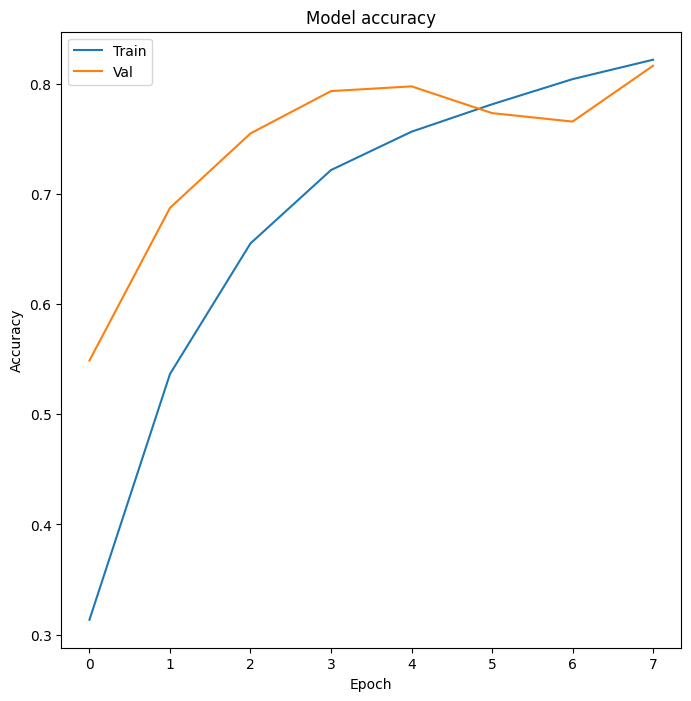

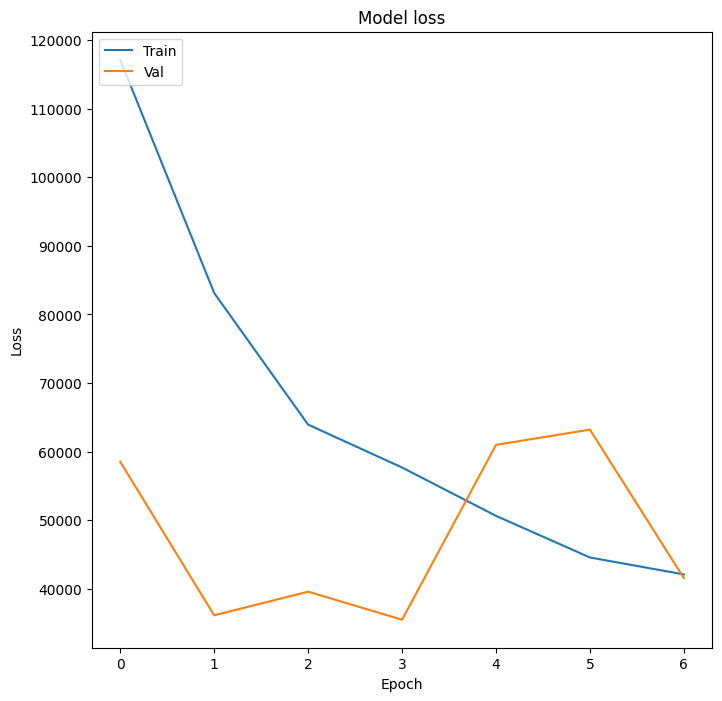

In [50]:
# Plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Testing

In [51]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {np.round(test_loss, 2)}, Test Accuracy: {np.round(test_accuracy, 2)}")

204/204 [==============================] - 7s 32ms/step - loss: 38807.5039 - sparse_categorical_accuracy: 0.8135
Test Loss: 38807.5, Test Accuracy: 0.81


# Evaluation
## Generate a confusion matrix for train, val and test data.

In [52]:
# Predict and generate confusion matrix
# For Train Data
train_predictions = model.predict(data_loader.get_train())
train_pred_labels = np.argmax(train_predictions, axis=1)

# For validation Data
val_predictions = model.predict(data_loader.get_val())
val_pred_labels = np.argmax(val_predictions, axis=1)

# For Test Data
test_predictions = model.predict(data_loader.get_test())
test_pred_labels = np.argmax(test_predictions, axis=1)

204/204 [==============================] - 7s 32ms/step


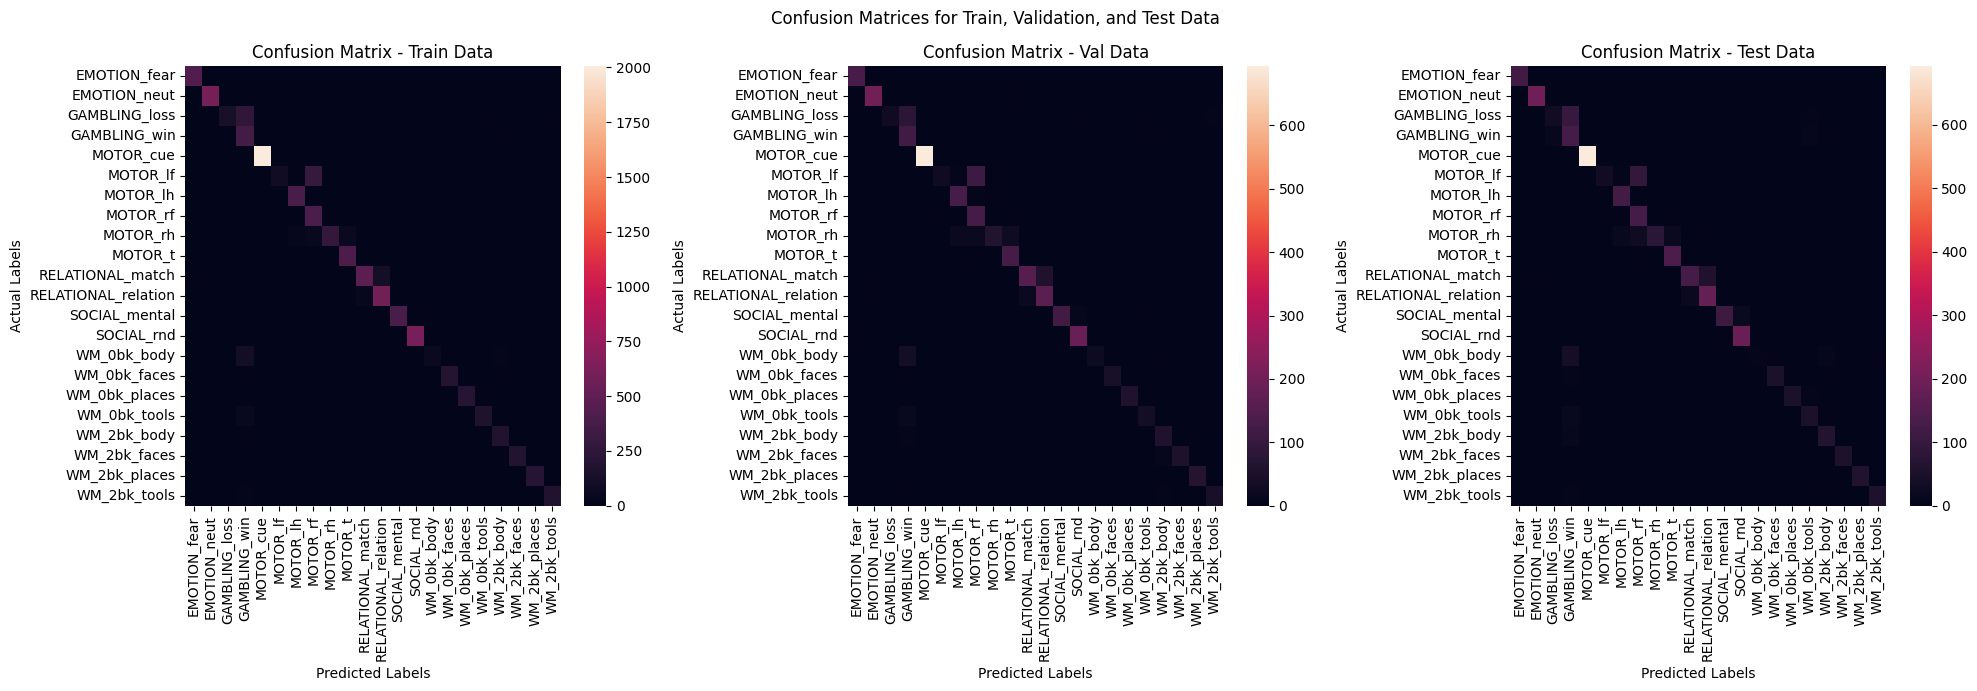

In [53]:
# Compute confusion matrices with placeholder labels
train_cm = confusion_matrix(data_loader.train_labels, train_pred_labels)
test_cm = confusion_matrix(data_loader.test_labels, test_pred_labels)
val_cm = confusion_matrix(data_loader.val_labels, val_pred_labels)
# Convert placeholder labels to actual label names
actual_labels = data_loader.convert_labels(np.array(data_loader.unique_labels))

# Create subplots for the confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Plotting confusion matrix for train data
sns.heatmap(train_cm, annot=False, fmt="d", xticklabels=actual_labels, yticklabels=actual_labels, ax=axes[0])
axes[0].set_title('Confusion Matrix - Train Data')
axes[0].set_ylabel('Actual Labels')
axes[0].set_xlabel('Predicted Labels')

# Plotting confusion matrix for validation data
sns.heatmap(val_cm, annot=False, fmt="d", xticklabels=actual_labels, yticklabels=actual_labels, ax=axes[1])
axes[1].set_title('Confusion Matrix - Val Data')
axes[1].set_ylabel('Actual Labels')
axes[1].set_xlabel('Predicted Labels')

# Plotting confusion matrix for test data
sns.heatmap(test_cm, annot=False, fmt="d", xticklabels=actual_labels, yticklabels=actual_labels, ax=axes[2])
axes[2].set_title('Confusion Matrix - Test Data')
axes[2].set_ylabel('Actual Labels')
axes[2].set_xlabel('Predicted Labels')

plt.suptitle('Confusion Matrices for Train, Validation, and Test Data')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# More comprehensive training of the model
## Running multiple combinations
Run this to train the model on different combinations of window sizes and tasks. For further inspection, this generates an image containing confusion matrices for train, val and test data. Outputs a dictionary. Key is the used combination and values are a dictionary containing Accuracy, Training Time, path to the confusion matrix and a list containing the 3 confusion matrices.

In [55]:
# Testing different window sizes and tasks
import time
import numpy as np

# make the dir confusion_matrices if it does not exist
if not os.path.exists('./confusion_matrices'):
    os.makedirs('./confusion_matrices')

# Define the hyperparameter space
window_sizes = [
    [20],
    [10, 20],
    [5, 10, 20]
]

task_combinations = [
    ['GAMBLING', 'SOCIAL'],
    ['GAMBLING', 'SOCIAL', 'EMOTION'],
    ['EMOTION', 'GAMBLING', 'RELATIONAL', 'SOCIAL'],
    ['MOTOR', 'WM', 'EMOTION', 'GAMBLING', 'RELATIONAL', 'SOCIAL']
]

# Calculate the total number of combinations to inform progress
total_combinations = len(task_combinations) * len(window_sizes)
current_combination = 1  # Initialize the current combination counter

# Results dictionary
results = {}

# Hyperparameters for the model
learning_rate = 1e-4
batch_size = 16
epochs = 100
n_subjects = N_SUBJECTS  
hcp_dir = HCP_DIR 
run_direction = RUN_DIRECTION['RL'] 

# Iterate over all combinations of hyperparameters
for tasks in task_combinations:
    for S in window_sizes:
        print(f'Testing combination {current_combination} / {total_combinations}: Tasks {tasks}, Window Sizes {S}')

        config_id = f'Tasks: {"_".join(tasks)}, Windows: {"_".join(map(str, S))}'

        # Load data
        data_loader = DataLoader(batch_size=batch_size, tasks=tasks, subjects=range(n_subjects), dir=hcp_dir, run_direction=run_direction, s_max=max(S), random_state=42)
        train_data = data_loader.get_train()
        val_data = data_loader.get_val()
        test_data = data_loader.get_test()
        
        # Build the model
        input_shape = (data_loader.max_seq_len, n_rois)  # [Time, ROIs]
        n_classes = len(data_loader.unique_labels)
        model = build_model(input_shape=input_shape, ff_dim=64, n_classes=n_classes, S=S)
        
        # Compile the model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

        start_time = time.time()
        # Fit the model
        model.fit(train_data, epochs=epochs, validation_data=val_data, verbose=2, callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        ])
        training_time = time.time() - start_time

        # Evaluate the model
        test_loss, test_acc = model.evaluate(test_data)
        
        # Predict and generate confusion matrix
        # For Train Data
        train_predictions = model.predict(data_loader.get_train())
        train_pred_labels = np.argmax(train_predictions, axis=1)

        # For validation Data
        val_predictions = model.predict(data_loader.get_val())
        val_pred_labels = np.argmax(val_predictions, axis=1)

        # For Test Data
        test_predictions = model.predict(data_loader.get_test())
        test_pred_labels = np.argmax(test_predictions, axis=1)

        # proceed to compute the confusion matrix using the predictions made
        train_cm = confusion_matrix(data_loader.train_labels, train_pred_labels)
        test_cm = confusion_matrix(data_loader.test_labels, test_pred_labels)
        val_cm = confusion_matrix(data_loader.val_labels, val_pred_labels)
        actual_labels = data_loader.convert_labels(np.array(data_loader.unique_labels))
        # Save the confusion matrix as an image

        # Create subplots for the confusion matrices
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))

        # Plotting confusion matrix for train data
        sns.heatmap(train_cm, annot=False, fmt="d", xticklabels=actual_labels, yticklabels=actual_labels, ax=axes[0])
        axes[0].set_title('Confusion Matrix - Train Data')
        axes[0].set_ylabel('Actual Labels')
        axes[0].set_xlabel('Predicted Labels')

        # Plotting confusion matrix for validation data
        sns.heatmap(val_cm, annot=False, fmt="d", xticklabels=actual_labels, yticklabels=actual_labels, ax=axes[1])
        axes[1].set_title('Confusion Matrix - Val Data')
        axes[1].set_ylabel('Actual Labels')
        axes[1].set_xlabel('Predicted Labels')

        # Plotting confusion matrix for test data
        sns.heatmap(test_cm, annot=False, fmt="d", xticklabels=actual_labels, yticklabels=actual_labels, ax=axes[2])
        axes[2].set_title('Confusion Matrix - Test Data')
        axes[2].set_ylabel('Actual Labels')
        axes[2].set_xlabel('Predicted Labels')

        plt.suptitle(f'Confusion Matrix for tasks: {tasks} and window sizes: {S}')
        plt.savefig(f'./confusion_matrices/cm_tasks_{"_".join(tasks)}_windows_{"_".join(map(str, S))}.png', bbox_inches='tight')
        plt.close()

        # Log the accuracy and training time
        print(f'Tasks: {tasks}, Window Sizes: {S}, Accuracy: {test_acc}, Training Time: {training_time}')
        # Collect results
        results[config_id] = {
            'Accuracy': test_acc,
            'Training Time': (time.time() - start_time) / 60,
            'Confusion Matrix Image Path': f'./confusion_matrices/cm_{config_id.replace(", ", "_").replace(": ", "-")}.png',
            'Confusion Matrices': [train_cm, val_cm, test_cm]
        }
        current_combination += 1  # Move to the next combination
print(results)

Testing combination 1 / 12: Tasks ['GAMBLING', 'SOCIAL'], Window Sizes [20]
Epoch 1/100
115/115 - 10s - loss: 121846.0078 - sparse_categorical_accuracy: 0.2842 - val_loss: 23684.6074 - val_sparse_categorical_accuracy: 0.4639 - 10s/epoch - 86ms/step
Epoch 2/100
115/115 - 8s - loss: 77207.6406 - sparse_categorical_accuracy: 0.4268 - val_loss: 22254.8926 - val_sparse_categorical_accuracy: 0.6574 - 8s/epoch - 73ms/step
Epoch 3/100
115/115 - 8s - loss: 49835.8320 - sparse_categorical_accuracy: 0.5716 - val_loss: 26102.7930 - val_sparse_categorical_accuracy: 0.7344 - 8s/epoch - 68ms/step
Epoch 4/100
115/115 - 8s - loss: 33562.3633 - sparse_categorical_accuracy: 0.7175 - val_loss: 15822.6494 - val_sparse_categorical_accuracy: 0.8459 - 8s/epoch - 70ms/step
Epoch 5/100
115/115 - 8s - loss: 26372.4805 - sparse_categorical_accuracy: 0.7749 - val_loss: 16152.8691 - val_sparse_categorical_accuracy: 0.8426 - 8s/epoch - 72ms/step
Epoch 6/100
115/115 - 9s - loss: 23567.3008 - sparse_categorical_accura

KeyboardInterrupt: 

# Inspecting the Output of Layers

## Example: Output of the temporal hypergraph layer

Note that the number at the end of the layer name changes. To work, this needs to be adjusted. The current number can be found in the model summary.

In [ ]:
temoral_hypergraph_layer_name = 'temporal_hypergraph_layer_25'

In [ ]:
# get single element from batch
batch = test_data.take(1)

In [ ]:
# Create a new model for inspection that outputs the adjacency matrix
inspection_model = models.Model(inputs=model.input, outputs=model.get_layer(temoral_hypergraph_layer_name).output)

# Predict with the inspection model to get the adjacency matrix
adjacency_matrices = inspection_model.predict(batch)

In [ ]:
print(adjacency_matrices.shape)
# get single element from batch
first = adjacency_matrices[0]
print(first.shape)

Note the visualisation assumes 4 adjacency matrices. This means the maximum time series length T / S_MAX should be 4 to generate 4 hypergraph segments in the temporal hypergraph.

In [ ]:
# split up the adjacency matrix into the different segments of size 40 x 360
n_segments = first.shape[0]
segments = [first[i] for i in range(n_segments)]

# binarise each segment
binary_segments = [np.where(segment >= 1, 1, 0) for segment in segments]

# Visualise all 4 segments with time step as label
fig_size = (15, 10)  # Adjust the size of the figure
fig, axs = plt.subplots(2, 2, figsize=fig_size)
axs = axs.flatten()

for i, ax in enumerate(axs):
    pos = ax.imshow(binary_segments[i], cmap='viridis', aspect='auto', interpolation='none')
    ax.set_title(f'Segment {i+1}', pad=20)

# Add a color bar
fig.colorbar(pos, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)

plt.show()

To see a hypergraph reprentation, use hypernetx to create hypergraph objects and then visualise them.

In [ ]:
# generate hypergraphs for each segment
hypergraphs = []
for i, segment in enumerate(binary_segments):
    hyperedges = []
    for j in range(segment.shape[0]):
        hyperedges.append(set(np.where(segment[j])[0]))

    H = hnx.Hypergraph(hyperedges)
    hypergraphs.append(H)
hypergraphs = [graph.dual().collapse_nodes_and_edges() for graph in hypergraphs]

In [ ]:
# Set the number of rows and columns for subplot grid
# 2x2 grid for 4 hypergraphs
nrows = 2
ncols = 2

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 12)) 

# Flatten the array of axes if necessary
axs = axs.flatten()

# Plot each hypergraph in its subplot
for i, (graph, ax) in enumerate(zip(hypergraphs, axs)):
    hnx.draw(graph, ax=ax)
    ax.set_title(f"Segment {i+1}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()